In [1]:
import numpy as np
import sep

In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = [10.,8.]

In [3]:
fname = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
hdu_list = fits.open(fname)
hdu_list.info()

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   


In [4]:
image_data = hdu_list[0].data

In [5]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(3600, 3600)


In [6]:
hdu_list.close()

In [7]:
image_data = fits.getdata(fname)
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(3600, 3600)


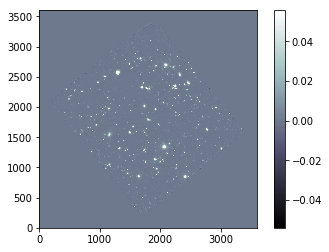

In [29]:
#show the image
m,s = np.mean(image_data), np.std(image_data)
plt.imshow(image_data, interpolation='nearest',cmap='bone', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()

In [14]:
#measure spatially varying background on image
#change byte data to read image
image_data_new = image_data.byteswap().newbyteorder()
bkg = sep.Background(image_data_new)

In [15]:
bkg = sep.Background(image_data_new, mask=mask, bw=64, bh=64, fw=3, fh=3)

NameError: name 'mask' is not defined

In [16]:
#get global mean and noise of image's background
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [17]:
#evaluate background as 2-D array but same size as original image
bkg_image = bkg.back()
#bkg_image = np.array(bkg)

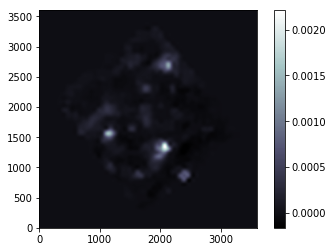

In [28]:
#show background
plt.imshow(bkg_image,interpolation='nearest',cmap='bone',origin='lower')
plt.colorbar();
#fig.savefig('plot.pdf')

In [19]:
#evaluate background noise as 2-D array, same size as original image
bkg_rms = bkg.rms()

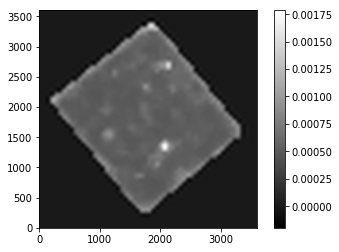

In [20]:
#show background noise
plt.imshow(bkg_rms,interpolation='nearest',cmap='gray',origin='lower')
plt.colorbar();

In [21]:
#subtract background
image_data_sub = image_data - bkg

In [22]:
#set detection threshold to be a constant value of 1.5*sigma
#sigma=global background rms
objects = sep.extract(image_data_sub, 1.5, err=bkg.globalrms)

In [23]:
#number of objects detected
len(objects)

8640

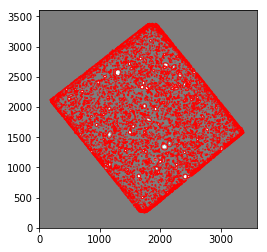

In [24]:
#over-plot the object coordinates with some parameters on the image
#this will check where the detected objects are
from matplotlib.patches import Ellipse

#plot background-subtracted image
fig, ax = plt.subplots()
m,s = np.mean(image_data_sub), np.std(image_data_sub)
im = ax.imshow(image_data_sub,interpolation='nearest',cmap='gray',
               vmin=m-s,vmax=m+s,origin='lower')

#plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i],objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i]*180./np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

#fig.savefig('plot.png')

In [25]:
#see available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [26]:
#perform circular aperture photometry 
#with a 3 pixel radius at locations of the objects
flux, fluxerr, flag = sep.sum_circle(image_data_sub,objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [27]:
#show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877
